### RNN

In [1]:
!pip install datasets

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [3]:
# 定义超参
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
raw_datasets = load_dataset('code_search_net', 'python')
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

Using the latest cached version of the module from C:\Users\shrek\.cache\huggingface\modules\datasets_modules\datasets\code_search_net\8f2524e6b62f65af5f5d65c53715c654db7b08dc93e0b7bcce2ab2f286a75be1 (last modified on Mon Jun 16 10:48:04 2025) since it couldn't be found locally at code_search_net, or remotely on the Hugging Face Hub.


In [5]:
class RNNCell(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size 
        self.hidden_size = hidden_size
        self.i2h = nn.Linear((input_size + hidden_size), hidden_size)

    def forward(self, input, hidden=None):
        # input: (1, I)   I: 特征个数 = 文本嵌入里的 C
        # hidden: (1, H)
        if hidden is None:
            hidden = self.init_hidden(input.device)
        combined = torch.cat((input, hidden), dim=-1)  # (1, I + H)
        hidden = F.relu(self.i2h(combined))            # (1,     H)
        return hidden
    
    def init_hidden(self, device):
        return torch.zeros((1, self.hidden_size), device=device)

In [6]:
r_model = RNNCell(2, 3)
x = torch.randn(4, 1, 2) # 文本个数是4， 单词个数是1， 词向量维度(特征维度)是2
hidden = None

for i in range(x.shape[0]):
    hidden = r_model(x[i], hidden)
    print(hidden)

tensor([[0.0973, 0.0144, 0.0000]], grad_fn=<ReluBackward0>)
tensor([[0.0000, 0.0000, 0.4002]], grad_fn=<ReluBackward0>)
tensor([[0.0000, 0.3787, 0.0000]], grad_fn=<ReluBackward0>)
tensor([[0.0218, 0.1896, 0.0000]], grad_fn=<ReluBackward0>)


In [7]:
class CharRNN(nn.Module):
    def __init__(self, vs): # vs: vocab_size
        super().__init__()
        self.emb = nn.Embedding(vs, 30) # (1, 30)
        self.rnn = RNNCell(30, 50)
        self.lm = nn.Linear(50, vs) # (1, vs)

    def forward(self, input, hidden=None):
        # input: (1, 1)
        # hidden: (1, 50)
        embedding = self.emb(input) # (1, 30)
        hidden = self.rnn(embedding, hidden) # (1, 50)
        output = self.lm(hidden) # (1, vs)
        return output, hidden

In [8]:
class CharTokenizer:
    def __init__(self, data, end_ind=0):
        # data : list[str]
        chars = sorted(list(set("".join(data))))
        self.char2ind = {char: i + 1 for i, char in enumerate(chars)}
        # self.char2ind["<|b|>"] = begin_ind
        self.char2ind["<|e|>"] = end_ind
        self.ind2char = {i: char for char, i in self.char2ind.items()}
        # self.begin_ind = begin_ind
        self.end_ind = end_ind

    def encode(self, text):
        # text : str
        return [self.char2ind[i] for i in text]

    def decode(self, inds):
        # inds : list[int] or int
        if isinstance(inds, int):
            inds = [inds]
        return [self.ind2char[i] for i in inds]

In [9]:
tokenizer = CharTokenizer(datasets['whole_func_string'])
test_str = 'def f(x):'

In [10]:
re = tokenizer.encode(test_str)
print(re)
''.join(tokenizer.decode(re))
''.join(tokenizer.decode(range(len(tokenizer.char2ind))))

[70, 71, 72, 2, 72, 10, 90, 11, 28]


'<|e|>\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~ö'

In [11]:
c_model = CharRNN(len(tokenizer.char2ind)).to(device)
c_model

CharRNN(
  (emb): Embedding(98, 30)
  (rnn): RNNCell(
    (i2h): Linear(in_features=80, out_features=50, bias=True)
  )
  (lm): Linear(in_features=50, out_features=98, bias=True)
)

In [12]:
# 测试数据
test_inputs = torch.tensor(tokenizer.encode('d'), device=device)
output, hidden = c_model(test_inputs)
output.shape, hidden.shape

(torch.Size([1, 98]), torch.Size([1, 50]))

In [13]:
# 实现一个生成函数
@torch.no_grad()
def generate(model, idx, tokenizer, max_tokens=300):
    # idx: (1,)
    out = idx.tolist()
    hidden = None
    model.eval()
    for _ in range(max_tokens):
        outputs, hidden = model(idx, hidden)
        probs = F.softmax(outputs, dim=-1) # (1, 99)
        # 随机生成下一个token
        next_token = torch.multinomial(probs, num_samples=1) # (1, 1)
        out.append(next_token.item())
        idx = next_token.squeeze(0)
        if out[-1] == tokenizer.end_ind:
            break
    model.train()
    return out

In [14]:
test_inputs = torch.tensor(tokenizer.encode('d'), device=device)
print(''.join(tokenizer.decode(generate(c_model, test_inputs, tokenizer))))

d*ZO(m/of("YP{BZE G|uw=3:1'Z$?Q9)N[{KQ=CK(AM:iKcaR;+Q3j<sAegWS$ö0Px!q9T3"yum5Za)'W~]\Wm&B"({r
cdtM=^DA11zk<|e|>


In [15]:
# 数据处理 inputs and labels
def process(text, tokenizer):
    enc = tokenizer.encode(text)
    inputs = enc
    labels = enc[1:] + [tokenizer.end_ind]
    return torch.tensor(inputs, device=device), torch.tensor(labels, device=device)

In [16]:
process(test_str, tokenizer)

(tensor([70, 71, 72,  2, 72, 10, 90, 11, 28], device='cuda:0'),
 tensor([71, 72,  2, 72, 10, 90, 11, 28,  0], device='cuda:0'))

In [19]:
# train
epoches = 1
lossi = []
optimizer = optim.Adam(c_model.parameters(), lr=learning_rate)

for epoch in range(epoches):
    for data in datasets:
        inputs, labels = process(data['whole_func_string'], tokenizer)
        lens = len(inputs)
        _loss = 0.0
        hidden = None
        for i in range(lens):
            output, hidden = c_model(inputs[i].unsqueeze(0), hidden)  # 维度要等于1
            _loss += F.cross_entropy(output, labels[i].unsqueeze(0)) / lens     # 维度要等于1
        lossi.append(_loss.item())
        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

In [22]:
test_inputs = torch.tensor(tokenizer.encode('d'), device=device)
print(''.join(tokenizer.decode(generate(c_model, test_inputs, tokenizer))))

doprups.ese:
         Lone theuat. = itue<|e|>


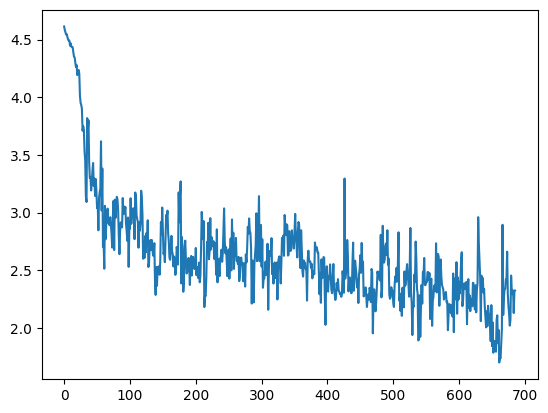

In [23]:
plt.plot(lossi)